In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch 


In [4]:
# load international_matches.csv into a dataframe
df = pd.read_csv('./DL_HW2/Data/HW2_data/international_matches.csv')

# display the last 10 rows of the dataframe
print(df.tail(10))

             date               home_team            away_team  \
23911  2022-06-14                 Ukraine  Republic of Ireland   
23912  2022-06-14  Bosnia and Herzegovina              Finland   
23913  2022-06-14                 Romania           Montenegro   
23914  2022-06-14              Luxembourg        Faroe Islands   
23915  2022-06-14                  Turkey            Lithuania   
23916  2022-06-14                 Moldova              Andorra   
23917  2022-06-14           Liechtenstein               Latvia   
23918  2022-06-14                   Chile                Ghana   
23919  2022-06-14                   Japan              Tunisia   
23920  2022-06-14          Korea Republic                Egypt   

      home_team_continent away_team_continent  home_team_fifa_rank  \
23911              Europe              Europe                   27   
23912              Europe              Europe                   59   
23913              Europe              Europe                  

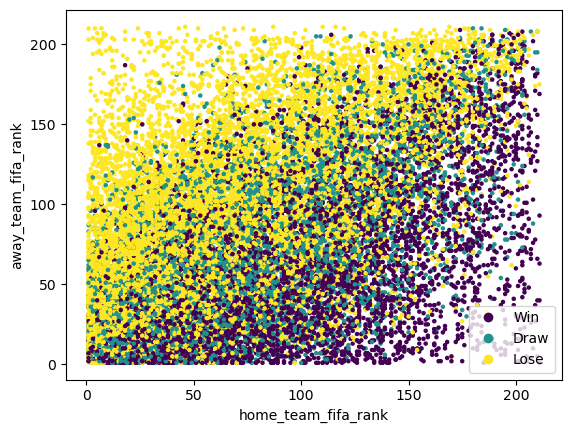

In [7]:
# create a new column called home_team_result
# if home_team_score > away_team_score, home_team_result = 1
# if home_team_score == away_team_score, home_team_result = 0
# if home_team_score < away_team_score, home_team_result = -1
home_team_result = df['home_team_score'] - df['away_team_score']
home_team_result = pd.DataFrame(np.sign(home_team_result), columns=['home_team_result'])
# scatter plot with home_team_fifa_rank on the x-axis and away_team_fifa_rank on the y-axis with the color of home_team_result
scatter = plt.scatter(x=df['home_team_fifa_rank'], y=df['away_team_fifa_rank'], c=home_team_result.values, s=5)
plt.xlabel("home_team_fifa_rank")
plt.ylabel("away_team_fifa_rank")
plt.legend(handles=scatter.legend_elements()[0],
labels=['Win', 'Draw', 'Lose'])
plt.show()
# set home_team_result = 2 if home_team_result = -1
home_team_result[home_team_result == -1] = 2

In [8]:
# remove the rows where both home_team_total_fifa_points and away_team_total_fifa_points are 0
columns = ["home_team_fifa_rank", "away_team_fifa_rank", "home_team_total_fifa_points", "away_team_total_fifa_points"]
df = df[columns]
# concatenate the home_team_result column to the dataframe
df = pd.concat([df, home_team_result], axis=1)
drop_indx = df[(df["away_team_total_fifa_points"] == 0) & (df["home_team_total_fifa_points"] == 0)].index
df = df.drop(drop_indx)

In [9]:
# # split the data into training and testing sets with a 75/25 split
train = df.sample(frac=0.75, random_state=0)
test = df.drop(train.index)
# split the training and testing sets into features and labels
train_features = train[columns]
train_labels = train['home_team_result']
test_features = test[columns]
test_labels = test['home_team_result']

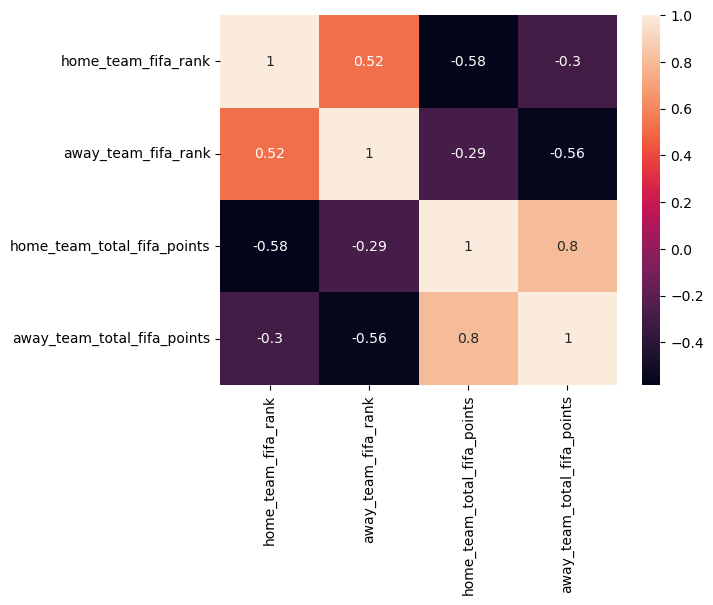

In [10]:
# plot heatmap of the correlation matrix
corr = df[columns].corr()
sns.heatmap(corr, annot=True)
plt.show()

In [11]:
# # normalize the data
mu, std = train_features.mean(), train_features.std()
train_features = (train_features - train_features.mean()) / train_features.std()
test_features = (test_features - test_features.mean()) / test_features.std()
# # convert the data into tensors
train_features = torch.tensor(train_features.values, dtype=torch.float32)
train_labels = torch.tensor(train_labels.values, dtype=torch.float32)
test_features = torch.tensor(test_features.values, dtype=torch.float32)
test_labels = torch.tensor(test_labels.values, dtype=torch.float32)

In [12]:
# use nn.module to create a neural network with 3 hidden layers and relu activation function
# to predict home_team_result
# the hidden layers have 10, 20, and 8 neurons respectively
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 8)
        self.fc4 = nn.Linear(8, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [18]:
# Define loss
criterion = nn.CrossEntropyLoss()
# define a function to train the model and return train and test accuracy and loss
def train_model(model, train_features, train_labels, test_features, test_labels, epochs, batch_size, verbose=True):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    for epoch in range(epochs):
        # train the model
        model.train()
        for i in range(0, len(train_features), batch_size):
            optimizer.zero_grad()
            output = model(train_features[i:i+batch_size])
            loss = criterion(output, train_labels[i:i+batch_size].long())
            loss.backward()
            optimizer.step()
        # calculate the train accuracy and loss
        model.eval()
        with torch.no_grad():
            output = model(train_features)
            loss = criterion(output, train_labels.long())
            train_loss.append(loss.item())
            train_acc.append((output.argmax(1) == train_labels).float().mean().item())
        # calculate the test accuracy and loss
        with torch.no_grad():
            output = model(test_features)
            loss = criterion(output, test_labels.long())
            test_loss.append(loss.item())
            test_acc.append((output.argmax(1) == test_labels).float().mean().item())
        if verbose:
            print("Epoch: {}, Train Accuracy: {}, Train Loss: {}, Test Accuracy: {}, Test Loss: {}".format(epoch+1, train_acc[-1], train_loss[-1], test_acc[-1], test_loss[-1]))
    return train_loss, test_loss, train_acc, test_acc, 

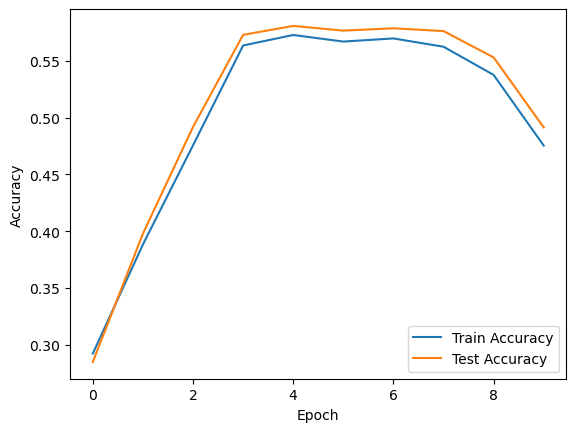

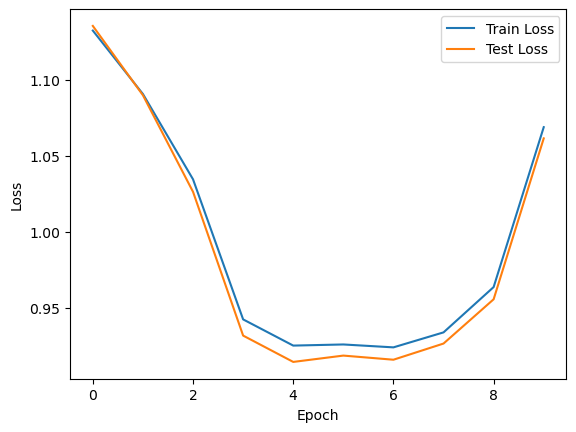

In [20]:
# choose best learning rate by changing the learning rate gradually for one iteration and plot the training and validation losses and accuracies
learning_rates = [1e-5, 3e-5,1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for lr in learning_rates:
    model = Net()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_features, train_labels, test_features, test_labels, epochs=4, batch_size=64, verbose=False)
    train_losses.append(train_loss[3])
    val_losses.append(val_loss[3])
    train_accs.append(train_acc[3])
    val_accs.append(val_acc[3])
# plot the train and test accuracy and loss
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch: 1, Train Accuracy: 0.2953667938709259, Train Loss: 1.0963683128356934, Test Accuracy: 0.285773366689682, Test Loss: 1.096809983253479
Epoch: 2, Train Accuracy: 0.4753171503543854, Train Loss: 1.0459233522415161, Test Accuracy: 0.4913151264190674, Test Loss: 1.042232632637024
Epoch: 3, Train Accuracy: 0.49048537015914917, Train Loss: 1.0189337730407715, Test Accuracy: 0.5041356682777405, Test Loss: 1.0120103359222412
Epoch: 4, Train Accuracy: 0.5439878702163696, Train Loss: 0.9866262078285217, Test Accuracy: 0.5612075924873352, Test Loss: 0.9776413440704346
Epoch: 5, Train Accuracy: 0.5588803291320801, Train Loss: 0.9577116966247559, Test Accuracy: 0.5760959386825562, Test Loss: 0.9473341703414917
Epoch: 6, Train Accuracy: 0.5623276233673096, Train Loss: 0.9405122399330139, Test Accuracy: 0.5748552680015564, Test Loss: 0.9297289252281189
Epoch: 7, Train Accuracy: 0.5653612613677979, Train Loss: 0.9324135780334473, Test Accuracy: 0.5760959386825562, Test Loss: 0.9216330647468567
E

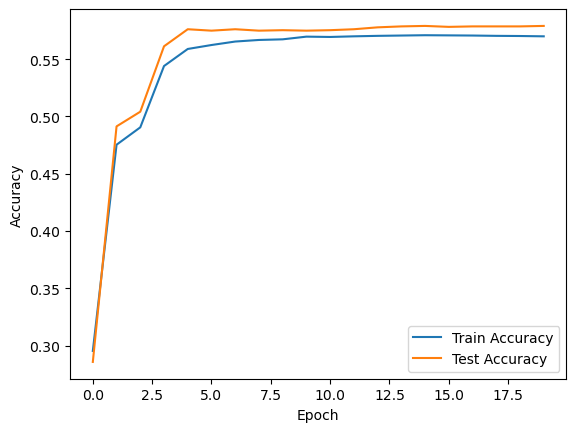

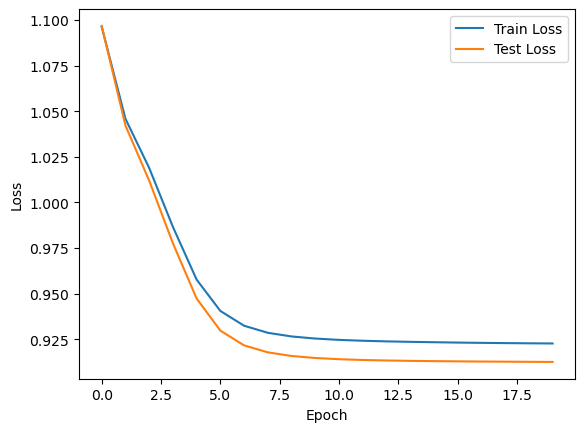

In [17]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
train_loss, val_loss, train_acc, val_acc = train_model(model, train_features, train_labels, test_features, test_labels, epochs=20, batch_size=64)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()